## Nano LLM [Large Language Model]

> Large Language models are one of the Generative AI, a type of Language Model that generates text, summarizes a text and so on. Today these LLM's are modernizing the chatbots that helps in assisting the humans in their daily tasks. These Language models are possible today, because of the prominent architecture proposed during 2017's known as  **Transformer**. 

> Transformer comprises of *Encoder* and *Decoder* parts. Encoder encodes the Context into vectors and Decoder decodes the context vector to generate text. Now these Transformers are not only used in Natural Language but also for Images, Audio and Multi-modal data. This Transformer was explained in the paper **Attention Is All You Need**.

![Transformer Stack](Images/Transformer.png)

> There is a layer in both Encoder and Decoder, where each token is then contextualized within the scope of the context window with other (unmasked) tokens via a parallel **Multi-head Self-Attention** mechanism allowing the signal for key tokens to be amplified and less important tokens to be diminished. There is a additional layer in Decoder known as **Multi-Head Cross-Attention** which uses context of encoded vectors to geneate the words relevant to Encoded Context. This is mainly used in Language Translation. 

    

    This notebook explains the nano version of LLM using Decoder-only Stack to generate text for the given prompt. The architecture is based on the paper Attention is All you Need.

### 1. Creation of Dataset

In [1]:
"""Import Packages"""

import os 
import torch
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import numpy as np
import re
from torchview import draw_graph # Ref and credits: https://github.com/mert-kurttutan/torchview for visualizing model graph.
from wordcloud import WordCloud, STOPWORDS
import time, sys
%matplotlib inline

In [2]:
"""Model Configuration"""

batch_size = 128
num_of_decoder_blocks = 2
embedding_dim = 512
num_of_attention_heads = 8
max_length = 50
pad_index = 0

In [3]:
"""First set of Data"""
# Dataset Ref: https://www.kaggle.com/datasets/pariza/bbc-news-summary

Root_Directory = "BBC News Summary/News Articles"

In [4]:
"""Extracting News Articles from above dataset"""

Text = []
for dir in os.listdir(Root_Directory):
        file_dir = os.path.join(Root_Directory, dir)
        for file in os.listdir(file_dir):
            text_file = os.path.join(file_dir, file)
            with open(text_file, 'r', encoding = 'unicode_escape') as F:
                text = F.read()
                Text.append(text)
len(Text)

2225

In [5]:
"""Second set of Data and Extraction of Dialogues of Marvel Characters"""
# Dataset Ref:https://www.kaggle.com/datasets/divaxshah/avengers-and-iron-man-movies-dataset

Root_Directory = "Avengers_Dialogues"
Text_1 = []
for file in os.listdir(Root_Directory):
    text_file = os.path.join(Root_Directory, file)
    with open(text_file, 'r', encoding = 'unicode_escape') as File:
        text = File.read()
        Text_1.append(text)
len(Text_1)


8

In [6]:
"""Third set of Data and Extraction of Scripts from Shakespeare Plays"""
# Dataset Ref: https://www.kaggle.com/datasets/kingburrito666/shakespeare-plays

Text_2 = []
text_file = 'Shakespeare/alllines.txt'
with open(text_file, 'r', encoding = 'unicode_escape') as File:
    text = File.read()
    Text_2.append(text)
len(Text_2)

1

In [7]:
"""Fourth set of Data and Extraction of texts of book"""

Text_3 = []
text_file = 'book.txt'
with open(text_file, 'r', encoding = 'unicode_escape') as File:
    text = File.read()
    Text_3.append(text)
len(Text_3)

1

In [8]:
Text_1 = ' '.join(Text_1).split('\n\n')
len(Text_1)

7505

In [9]:
Text_2 = Text_2[0].split('\n')
len(Text_2)

111397

In [10]:
Text_3 = Text_3[0].split('.')
len(Text_3)

400

In [11]:
Text = ' '.join(Text).split('\n\n')
len(Text)

10590

In [12]:
"""Splitting the above Text into individual sentences and Concatenating"""
Text = Text + Text_1 + Text_2[0:7505] + Text_3
len(Text)

26000

In [13]:
for idx in range(len(Text)):
    Text[idx] = re.sub('"', '', Text[idx])

Text[0:10]

['Ad sales boost Time Warner profit',
 'Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (Â£600m) for the three months to December, from $639m year-earlier.',
 'The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.',
 "Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to

In [14]:
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form."""
     # Ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490
    # Specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # General
    phrase = re.sub(r"'", '', phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
    
def preprocess_Eng(text): # Preprocessing of English sentences
    txt = text.lower()
    txt = decontractions(txt)
    txt = re.sub('\n', ' ', txt)
    txt = re.sub('[^A-Za-z0-9 ]+', '', txt)
    text = re.sub('[$)\?"’.°!;\'€%:,(/]', '', text)
    text = re.sub('\u200b', ' ', text)
    text = re.sub('\xa0', ' ', text)
    text = re.sub('-', ' ', text)
    txt = txt.strip() 
    return txt


In [15]:
"""Preprocess of Text corpus"""

for idx in range(len(Text)):
    Text[idx] = preprocess_Eng(Text[idx])

Text[0:10]

['ad sales boost time warner profit',
 'quarterly profits at us media giant timewarner jumped 76 to 113bn 600m for the three months to december from 639m yearearlier',
 'the firm which is now one of the biggest investors in google benefited from sales of highspeed internet connections and higher advert sales timewarner said fourth quarter sales rose 2 to 111bn from 109bn its profits were buoyed by oneoff gains which offset a profit dip at warner bros and less users for aol',
 'time warner said on friday that it now owns 8 of searchengine google but its own internet business aol had has mixed fortunes it lost 464000 subscribers in the fourth quarter profits were lower than in the preceding three quarters however the company said aols underlying profit before exceptional items rose 8 on the back of stronger internet advertising revenues it hopes to increase subscribers by offering the online service free to timewarner internet customers and will try to sign up aols existing customers for

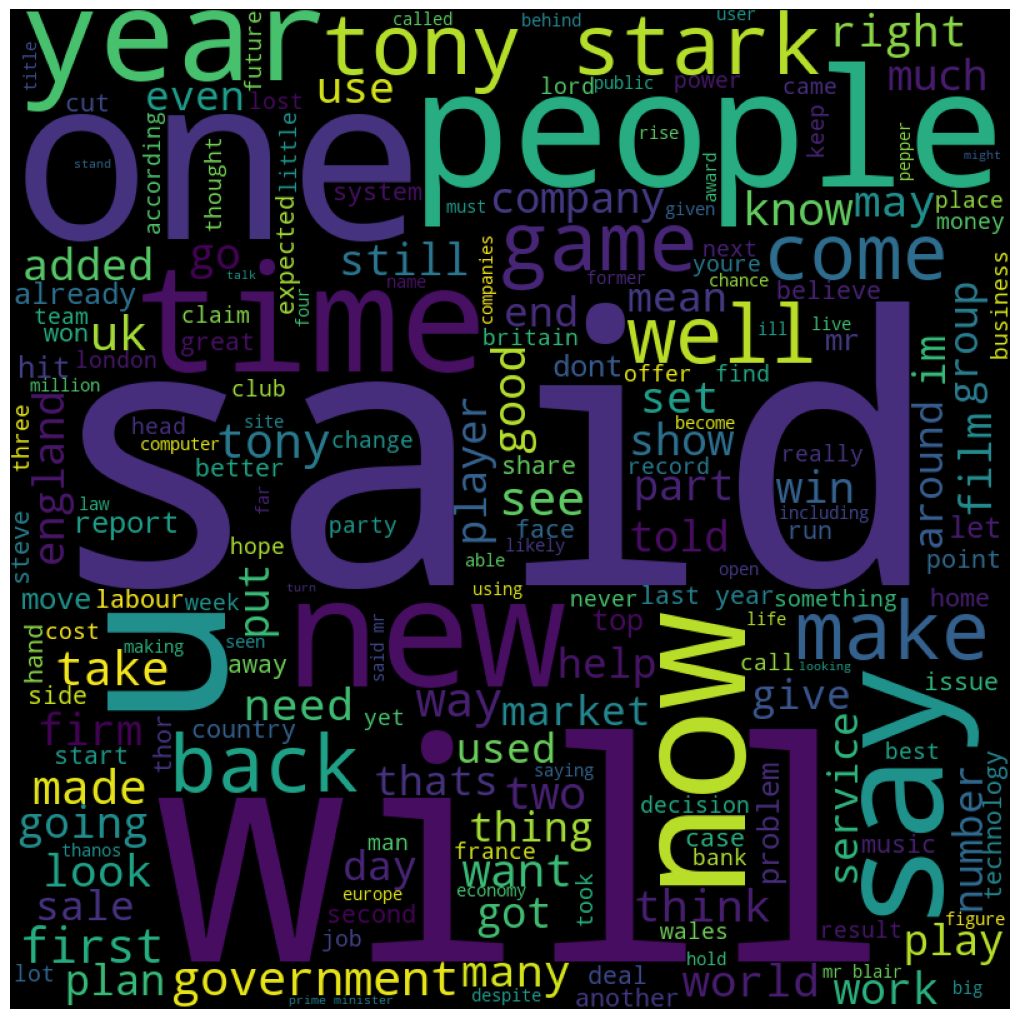

In [17]:
"""Visualizing the frequency of words present in Text corpus"""

stopwords_ = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 800, background_color = 'black', stopwords = stopwords_, min_font_size = 10).generate(" ".join(Text))

plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

In [18]:
"""Train and Val split"""

train_size = int(0.8 * len(Text))
val_size = len(Text) - train_size
train_size, val_size

(20800, 5200)

In [19]:
train, val = random_split(Text, [train_size, val_size], generator = torch.manual_seed(64))
len(train), len(val)

(20800, 5200)

In [20]:
"""Creating set of Unique words"""

Vocab = set()
for each in Text:
    Vocab.update(each.split())
Vocab = sorted(Vocab)

In [21]:
"""Creating Dictionary of Words for Tokenizer"""

Vocab_dict = {'<unk>': 1, '<sos>': 2, '<eos>': 3}
key = 4
for i in Vocab:
    Vocab_dict[i] = key
    key += 1

Vocab_size = len(Vocab_dict) + 1
Vocab_size

40629

In [22]:
"""Function to Tokenize the sentence into Integer tensor"""

def Tokenize(sentence):
    tokens2int = lambda x: Vocab_dict.get(x) if x in Vocab_dict.keys() else Vocab_dict.get('<unk>')
    #int2tokens = lambda x: list(Vocab_dict.keys())[list(Vocab_dict.values()).index(x)]
    sos_token = Vocab_dict.get('<sos>')
    eos_token = Vocab_dict.get('<eos>')
    length = len(sentence.split())
    Tokens = sentence.split() 
    if length > max_length - 1:
        Tokens = Tokens[0 : max_length - 1] 
        Tokenstoint_input = [tokens2int(Token) for Token in Tokens]
        Tokenstoint_input = [sos_token] + Tokenstoint_input
        out = Tokenstoint_input[1:] + [eos_token]
        return torch.tensor(Tokenstoint_input), torch.tensor(out)
    else:
        Tokenstoint_input = [tokens2int(Token) for Token in Tokens]
        Tokenstoint_input = [sos_token] + Tokenstoint_input
        out = Tokenstoint_input[1:] + [eos_token]
        Tokenstoint_input = Tokenstoint_input + [0] * ((max_length - 1) - length)
        out = out + [0] * ((max_length - 1) - length)
        return torch.tensor(Tokenstoint_input), torch.tensor(out)

In [23]:
"""Tokenize the Train Data"""

Data = list(map(Tokenize, list(iter(train))))
Train_Decoder_in, Train_Decoder_out = [], []
Train_Decoder_in += [Data[i][0] for i in range(len(Data))]
Train_Decoder_out += [Data[i][1] for i in range(len(Data))]
Train_Decoder_in, Train_Decoder_out = torch.stack(Train_Decoder_in), torch.stack(Train_Decoder_out)
Train_Decoder_in.size(), Train_Decoder_out.size()

(torch.Size([20800, 50]), torch.Size([20800, 50]))

In [24]:
"""Tokenize the Val Data"""

Data = list(map(Tokenize, list(iter(val))))
Val_Decoder_in, Val_Decoder_out = [], []
Val_Decoder_in += [Data[i][0] for i in range(len(Data))]
Val_Decoder_out += [Data[i][1] for i in range(len(Data))]
Val_Decoder_in, Val_Decoder_out = torch.stack(Val_Decoder_in), torch.stack(Val_Decoder_out)
Val_Decoder_in.size(), Val_Decoder_out.size()

(torch.Size([5200, 50]), torch.Size([5200, 50]))

In [25]:
"""Class to create Torch Dataset"""

class Custom_Dataset(Dataset):
    def __init__(self, In_Data: list, Out_Data: list):
        self.output = Out_Data
        self.input = In_Data

    def __len__(self):
        return len(self.input)
    
    """This Function creates mask object to mask future tokens of query token"""
    def mask(self):
        self.mask_object = torch.tril(torch.ones([self.input.size(1), self.input.size(1)], dtype = torch.bool))
        return self.mask_object
    
    def __getitem__(self, idx):
        x = self.input[idx]
        y = self.output[idx]
        x_mask = (x != pad_index) & self.mask() # Creation of Decoder input mask.
        return x, y, x_mask

In [26]:
train_dataset = Custom_Dataset(Train_Decoder_in, Train_Decoder_out)
val_dataset = Custom_Dataset(Val_Decoder_in, Val_Decoder_out)
len(train_dataset), len(val_dataset)

(20800, 5200)

In [27]:
"""Creation of Train and Validation Dataloader"""

Train_Dl = DataLoader(train_dataset, batch_size, shuffle = True, num_workers = 0, pin_memory = True)
Val_Dl = DataLoader(val_dataset, batch_size, num_workers = 0, pin_memory = True)

In [28]:
def get_default_device():
    """Use GPU if available, else CPU"""
    if torch.cuda.is_available():
        for i in range(torch.cuda.device_count()):
            print(torch.cuda.get_device_properties(i))
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move Tensors to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a Dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [29]:
device = get_default_device()
device

_CudaDeviceProperties(name='NVIDIA GeForce RTX 3060 Laptop GPU', major=8, minor=6, total_memory=6143MB, multi_processor_count=30)


device(type='cuda')

In [30]:
Train_Dl = DeviceDataLoader(Train_Dl, device)
Val_Dl = DeviceDataLoader(Val_Dl, device)

In [31]:
x, y, x_mask = next(iter(Train_Dl))
print(x)
print(y)
print(x_mask)

tensor([[    2,  4559,  8835,  ...,     0,     0,     0],
        [    2,  3936, 25605,  ...,     0,     0,     0],
        [    2, 39711,  5014,  ...,     0,     0,     0],
        ...,
        [    2,  5082,  4730,  ...,     0,     0,     0],
        [    2, 30111, 28672,  ...,     0,     0,     0],
        [    2,  4559, 15879,  ...,     0,     0,     0]], device='cuda:0')
tensor([[ 4559,  8835, 23571,  ...,     0,     0,     0],
        [ 3936, 25605, 32380,  ...,     0,     0,     0],
        [39711,  5014, 36791,  ...,     0,     0,     0],
        ...,
        [ 5082,  4730, 36352,  ...,     0,     0,     0],
        [30111, 28672, 17929,  ...,     0,     0,     0],
        [ 4559, 15879, 25920,  ...,     0,     0,     0]], device='cuda:0')
tensor([[[ True, False, False,  ..., False, False, False],
         [ True,  True, False,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         ...,
         [ True,  True,  True,  ..., False, False, 

In [32]:
x.size(), y.size(), x_mask.size()

(torch.Size([128, 50]), torch.Size([128, 50]), torch.Size([128, 50, 50]))

### 2. Decoder Layers

#### Embedding Layer

In [33]:
"""Class to create the embeddings of input tokens"""

class InputEmbedding(nn.Module):

    def __init__(self, Vocab_size: int, Embedding_dim: int):
        super(InputEmbedding, self).__init__()

        self.vocab_size = Vocab_size
        self.d_model = Embedding_dim
        self.embedding = nn.Embedding(self.vocab_size, self.d_model)

    """
    In the embedding layers, we multiply those weights by √dmodel [1].

    """
    def forward(self, x):
        return self.embedding(x) * np.sqrt(self.d_model)


#### Positional Encoding Layer

In [34]:
"""Class to encode position of each tokens using Sin and Cosine functions"""

class PositionalEncoding(nn.Module):

    def __init__(self, Word_Count: int, Embedding_dim: int):
        super(PositionalEncoding, self).__init__()

        self.d_model = Embedding_dim
        self.max_length = Word_Count
        PE = torch.zeros(self.max_length, self.d_model)
        #print(PE.size())
        for pos in range(self.max_length):
            for i in range(0, self.d_model, 2):
                PE[pos, i] = np.sin(pos / (10000 ** ((2 * i) / self.d_model)))
                PE[pos, i + 1] = np.cos(pos / (10000 ** ((2 * (i + 1)) / self.d_model)))
        PE = torch.unsqueeze(PE, 0).requires_grad_(False)
        self.register_buffer('PE', PE)
        #print(self.PE.size())

    """
    Since there is no recurrence and no convolution, in order for the model to make use of the
    order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence [1].
   
    """
    def forward(self, x):
        return x + self.PE[:, :x.size(1), :]

#### Feed-Forward Network Layer

$$ FFN(x) = max(0, xW_{1} + b_{1})W_{2} + b_{2} $$

In [35]:
"""Class to create Feed-Forward Network"""

class PositionwiseFeedForwardBlock(nn.Module):

    def __init__(self, Embedding_dim: int):
        super(PositionwiseFeedForwardBlock, self).__init__()

        self.d_model = Embedding_dim
        self.d_ff = self.d_model * 4
        self.linear_1 = nn.Linear(self.d_model, self.d_ff, bias = False)
        self.linear_2 = nn.Linear(self.d_ff, self.d_model, bias = False)
        self.relu = nn.ReLU(True)
        self.dropout = nn.Dropout(0.1)

    """
    The dimensionality of input and output is dmodel = 512, and the inner-layer has dimensionality
    dff = 2048 [1].

    """    
    def forward(self, x):           
        out = self.linear_1(x)
        out = self.relu(out)
        out = self.linear_2(out)
        out = self.dropout(out)
        return out

#### Residual Connection and Layer Normalization Layer

In [36]:
"""Class to create Residual Connection and to perform Layer Normalization"""

class ResidualConnection(nn.Module):
    def __init__(self, Embedding_dim: int):
        super(ResidualConnection, self).__init__()

        self.d_model = Embedding_dim
        self.layernorm = nn.LayerNorm(self.d_model)

    """
    We employ a residual connection around each of the two sub-layers, followed by layer normalization. 
    That is, the output of each sub-layer is LayerNorm(x + Sublayer(x)), where Sublayer(x) is the function implemented by the sub-layer
    itself. To facilitate these residual connections, all sub-layers in the model, as well as the embedding
    layers, produce outputs of dimension dmodel [1].

    """
    def forward(self, x, sublayer_x):
        return self.layernorm(x + sublayer_x)

#### Multi-Head Masked Attention Layer

$$ Attention(Q, K, V) = softmax(\frac{Q K^{T}}{\sqrt{dk}}) V $$ 
$$ MultiHead(Q, K, V ) = Concat(head_{1}, ..., head_{h})W^{O} $$
$$where$$ 
$$ head_{i} = Attention(QW^{Q}_{i}, KW^{K}_{i}, VW^{V}_{i}) $$

Where the projections are parameter matrices $ W_{i}^{Q} \in \mathbb{R}^{d_{model} \times d_{k}} $, $ W_{i}^{K} \in \mathbb{R}^{d_{model} \times d_{k}} $, $ W_{i}^{V} \in \mathbb{R}^{d_{model} \times d_{v}} $ and $ W_{i}^{O} \in \mathbb{R}^{hd_{v} \times d_{model}} $.

In this $ h = 8 $, so $ d_{k} = d_{v} = d_{model} / h = 64 $.



In [37]:
"""Class to create Masked Self-Attention for number of Heads"""
# Note: In this we do not employ Cross-Attention mechanism, since encoder stack is not used for this LLM.

class MultiHeadAttention(nn.Module):

    def __init__(self, num_heads: int, Embedding_dim: int):
        super(MultiHeadAttention, self).__init__()

        self.inf = 1e9
        self.dmodel = Embedding_dim
        self.h = num_heads
        self.dk = self.dv = self.dmodel // self.h
        self.Wo = nn.Linear(self.h * self.dv, self.dmodel, bias = False)
        self.Wq = nn.ModuleList([nn.Linear(self.dmodel, self.dk, bias = False) for _ in range(self.h)])
        self.Wk = nn.ModuleList([nn.Linear(self.dmodel, self.dk, bias = False) for _ in range(self.h)])
        self.Wv = nn.ModuleList([nn.Linear(self.dmodel, self.dv, bias = False) for _ in range(self.h)])
        self.dropout = nn.Dropout(0.1)

    """
    An attention function can be described as mapping a query and a set of key-value pairs to an output,
    where the query, keys, values, and output are all vectors. The output is computed as a weighted sum
    of the values, where the weight assigned to each value is computed by a compatibility function of the
    query with the corresponding key [1].

    """
    # Function to perfrom masked attention
    def attention(self, Wq, Wk, Wv, Q, K, V, mask):

        #print(Wq)

        q = Wq(Q)
        k = Wk(K)
        v = Wv(V)

        q = q.view(Q.size(0), Q.size(1), 1, self.dk).transpose(1, 2)
        k = k.view(K.size(0), K.size(1), 1, self.dk).transpose(1, 2)
        v = v.view(V.size(0), V.size(1), 1, self.dv).transpose(1, 2)

        attn_scores = q @ k.transpose(-2, -1) / np.sqrt(self.dk) # Calculation of Attention Scores

        if mask is not None:
            mask = mask.unsqueeze(1)
            attn_scores = attn_scores.masked_fill_(mask == 0, -self.inf)
        
        attn_scores = attn_scores.softmax(dim = -1)
        attn_values = attn_scores @ v # Attention is calculated based on above equation.
        attn_values = attn_values.transpose(1, 2).contiguous().view(Q.size(0), Q.size(1), 1 * self.dv)

        return attn_values, attn_scores
    
    """
    Instead of performing a single attention function with dmodel-dimensional keys, values and queries,
    we found it beneficial to linearly project the queries, keys and values h times with different, learned
    linear projections to dk, dk and dv dimensions, respectively [1].

    """
    def forward(self, Q, K, V, mask):
        Head_attention_values = []
        Head_attention_scores = []
        Q, K, V, mask = Q, K, V, mask
        for i in range(self.h): # Calculation of attention values for individual heads
            attn_values, attn_scores = self.attention(self.Wq[i], self.Wk[i], self.Wv[i], Q, K, V, mask)
            Head_attention_values.append(attn_values)
            Head_attention_scores.append(attn_scores)
        
        multiheadattn_values = self.Wo(torch.cat(Head_attention_values, -1)) 
        return multiheadattn_values      


#### Output Projection Layer

In [39]:
"""Class to create output logits"""

class OutputProjection(nn.Module):
    
    def __init__(self, Embedding_dim: int, Vocab_size: int):
        super(OutputProjection, self).__init__()

        self.dmodel = Embedding_dim
        self.vocab_size = Vocab_size
        self.linear = nn.Linear(self.dmodel, self.vocab_size, bias = False)
        #self.softmax = nn.LogSoftmax(dim = -1)
    
    def forward(self, x):
        out = self.linear(x)
        #out = self.softmax(out)
        return out


### 3. Decoder Block

In [40]:
"""Class to create Decoder block"""

class Decoder_Block(nn.Module):

    def __init__(self, vocab_size: int, embedding_dim: int, num_head: int, multihead_attention: MultiHeadAttention,
                 residual_connection: ResidualConnection, feed_forward: PositionwiseFeedForwardBlock):
        super(Decoder_Block, self).__init__()
        
        self.vocab_size = vocab_size
        self.d_model = embedding_dim
        self.h = num_head
        self.multi_head_attention = multihead_attention(self.h, self.d_model)
        self.add_and_norm = nn.ModuleList([residual_connection(self.d_model) for _ in range(2)])
        self.feed_forward = feed_forward(self.d_model)
   
    """
    This block includes layers of masked multi-head attention, residual connection & layer norm, feed-forward neural network and 
    residual connection & layer norm.

    """
    def forward(self, x, q, k ,v, mask):

        out = self.multi_head_attention(q, k, v, mask)
        out_1 = self.add_and_norm[0](x, out)
        out_1_1 = self.feed_forward(out_1)
        out_2 = self.add_and_norm[1](out_1, out_1_1)

        return out_2

### 4. Decoder Architecture

In [41]:
"""This final class completes the decoder by creating number of decoder blocks and producing the output logits"""

class Decoder(nn.Module):

    def __init__(self, decoder_stack: int, vocab_size: int, embedding_dim: int, num_head: int, max_length: int,
                 embedding: InputEmbedding, positional_encoding: PositionalEncoding, decoder_block: Decoder_Block, multihead_attention: MultiHeadAttention,
                 residual_connection: ResidualConnection, feed_forward: PositionwiseFeedForwardBlock, output_projection: OutputProjection):
        super(Decoder, self).__init__()
        self.N = decoder_stack
        self.vocab_size = vocab_size
        self.d_model = embedding_dim
        self.max_length = max_length
        self.dropout = nn.Dropout(0.1)

        self.input_embedding = embedding(self.vocab_size, self.d_model)
        self.positional_encoding = positional_encoding(self.max_length, self.d_model)
        self.output_projection = output_projection(self.d_model, self.vocab_size)
        #self.output_projection.linear.weight.data = self.input_embedding.embedding.weight.data

        self.block = nn.ModuleList([decoder_block(self.vocab_size, self.d_model, num_head, multihead_attention,
                                   residual_connection, feed_forward) for _ in range(self.N)])
        
        self.apply(self._init_weights)
        
    def _init_weights(self, module):

        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, 0.0, 0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, 0.0, 0.02)

        
    def forward(self, x, mask):
        
        out = self.input_embedding(x)
        out = self.positional_encoding(out)
        out = self.dropout(out)
        for i in range(self.N): # Iterating through number of blocks
            out = self.block[i](out, out, out, out, mask)
        out = self.output_projection(out)

        return out


### 5. Training and Evaluation

#### Learning Rate Scheduler 

$$ lrate = d_{model}^{-0.5} \cdot min(step_{-}num^{-0.5}, step_{-}num \cdot warmup_{-}steps^{-1.5}) $$

In [42]:
"""Class to create Learning Rate Scheduler"""

class LRScheduler():
    
    def __init__(self, optimizer, initial_lr: float, embedding_dim: int, warmup_steps: int):
        self.d_model = embedding_dim
        self.optimizer_ = optimizer
        self.lr = initial_lr
        self.warmup_steps_ = warmup_steps

    def zero_grad_(self):
        self.optimizer_.zero_grad()

    """
    This corresponds to increasing the learning rate linearly for the first warmup_steps training steps,
    and decreasing it thereafter proportionally to the inverse square root of the step number [1].

    """
    def step(self, step_num, loss):
        loss.backward()
        scaler = (self.d_model ** (-0.5)) * (min((step_num ** (-0.5)), (step_num * (self.warmup_steps_ ** (-1.5)))))
        lr = self.lr * scaler
        self.optimizer_.param_groups[0]['lr'] = lr
        self.optimizer_.step()

    def get_lr_(self):
        return self.optimizer_.param_groups[0]['lr']

    

In [43]:
"""Function for Train"""

def Train(model, x, y, mask, optimizer, nstep, pad_index = 0):
    torch.cuda.empty_cache()
    optimizer.zero_grad_()

    predicted = model(x, mask)
    loss_func = nn.CrossEntropyLoss(ignore_index = pad_index)
    loss = loss_func(predicted.view(-1, predicted.size(2)), y.view(-1))

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.2)
    optimizer.step(nstep, loss)
    lr = optimizer.get_lr_()

    return loss.item(), lr

In [44]:
"""Function for Evaluation"""

@torch.no_grad()
def Evaluation(model, batch, pad_index = 0):
    model.eval()
    x, y, mask = batch
    predicted = model(x, mask)
    loss_func = nn.CrossEntropyLoss(ignore_index = pad_index)
    loss = loss_func(predicted.view(-1, predicted.size(2)), y.view(-1))
    return {'val_loss': loss.detach()}
        

def Validation_Epoch_End(outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Calculation Validation batch mean loss.
    return {'val_loss': epoch_loss.item()}


In [45]:
"""Intialise of Decoder class"""

decoder = Decoder(num_of_decoder_blocks, Vocab_size, embedding_dim, num_of_attention_heads, max_length, 
                  InputEmbedding, PositionalEncoding, Decoder_Block,
                  MultiHeadAttention, ResidualConnection, PositionwiseFeedForwardBlock,
                  OutputProjection).to(device)

Num_of_parameters = sum(p.numel() for p in decoder.parameters())
print("Model Parameters : {:.3f} M".format(Num_of_parameters / 1e6)) # Prints Total number of Model Parameters.

Model Parameters : 47.900 M


In [46]:
"""Function to Train and Evaluate"""
def Fit(epochs, lr, warmup_steps):
    
    optim = torch.optim.AdamW(decoder.parameters(), lr = lr, betas = (0.9, 0.98), eps = 1e-9) # Initialise the optimizer.
    scheduled_optimizer = LRScheduler(optim, lr, embedding_dim, warmup_steps) # Intialise the Leaarnini rate scheduler for the above optimizer.
    
    Train_Loss = []
    Val_Loss = []
    for epoch in range(epochs):
        decoder.train()
        nstep = 0
        LR = []
        Losses = []
        for x, y, mask in tqdm(Train_Dl):
            nstep += 1
            loss, lr_ = Train(decoder, x, y, mask, scheduled_optimizer, nstep, pad_index = 0)
            Losses.append(torch.tensor(loss))
            LR.append(lr_)

        train_mean_loss = torch.stack(Losses).mean().item()
        Train_Loss.append(train_mean_loss)

        val_outputs = [Evaluation(decoder, batch) for batch in Val_Dl]
        result = Validation_Epoch_End(val_outputs)
        Val_Loss.append(result['val_loss'])

        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}".format(
            epoch + 1, train_mean_loss, result['val_loss']))


    return Train_Loss, Val_Loss, LR

In [47]:
"""Training Config"""
epochs = 250
warmup_steps = 140
lr = 3e-3

In [48]:
"""Kickstart the Training"""
history = Fit(epochs, lr, warmup_steps)

  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [1], train_loss: 10.2595, val_loss: 9.5021


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [2], train_loss: 9.3219, val_loss: 8.9396


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [3], train_loss: 8.7904, val_loss: 8.4759


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [4], train_loss: 8.3363, val_loss: 8.0849


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [5], train_loss: 7.9567, val_loss: 7.7724


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [6], train_loss: 7.6603, val_loss: 7.5443


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [7], train_loss: 7.4456, val_loss: 7.3926


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [8], train_loss: 7.3019, val_loss: 7.2948


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [9], train_loss: 7.2040, val_loss: 7.2299


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [10], train_loss: 7.1336, val_loss: 7.1802


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [11], train_loss: 7.0752, val_loss: 7.1403


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [12], train_loss: 7.0251, val_loss: 7.1075


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [13], train_loss: 6.9817, val_loss: 7.0758


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [14], train_loss: 6.9404, val_loss: 7.0470


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [15], train_loss: 6.9002, val_loss: 7.0218


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [16], train_loss: 6.8623, val_loss: 6.9930


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [17], train_loss: 6.8220, val_loss: 6.9683


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [18], train_loss: 6.7862, val_loss: 6.9436


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [19], train_loss: 6.7498, val_loss: 6.9198


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [20], train_loss: 6.7161, val_loss: 6.8968


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [21], train_loss: 6.6813, val_loss: 6.8761


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [22], train_loss: 6.6488, val_loss: 6.8565


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [23], train_loss: 6.6172, val_loss: 6.8313


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [24], train_loss: 6.5860, val_loss: 6.8147


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [25], train_loss: 6.5551, val_loss: 6.7927


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [26], train_loss: 6.5257, val_loss: 6.7756


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [27], train_loss: 6.4973, val_loss: 6.7607


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [28], train_loss: 6.4684, val_loss: 6.7520


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [29], train_loss: 6.4425, val_loss: 6.7318


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [30], train_loss: 6.4155, val_loss: 6.7133


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [31], train_loss: 6.3887, val_loss: 6.6984


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [32], train_loss: 6.3650, val_loss: 6.6828


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [33], train_loss: 6.3404, val_loss: 6.6734


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [34], train_loss: 6.3179, val_loss: 6.6590


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [35], train_loss: 6.2945, val_loss: 6.6463


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [36], train_loss: 6.2729, val_loss: 6.6354


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [37], train_loss: 6.2501, val_loss: 6.6213


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [38], train_loss: 6.2289, val_loss: 6.6133


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [39], train_loss: 6.2099, val_loss: 6.5967


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [40], train_loss: 6.1895, val_loss: 6.5903


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [41], train_loss: 6.1697, val_loss: 6.5782


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [42], train_loss: 6.1492, val_loss: 6.5684


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [43], train_loss: 6.1309, val_loss: 6.5628


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [44], train_loss: 6.1130, val_loss: 6.5534


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [45], train_loss: 6.0950, val_loss: 6.5423


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [46], train_loss: 6.0774, val_loss: 6.5378


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [47], train_loss: 6.0590, val_loss: 6.5297


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [48], train_loss: 6.0430, val_loss: 6.5136


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [49], train_loss: 6.0251, val_loss: 6.5028


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [50], train_loss: 6.0093, val_loss: 6.4965


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [51], train_loss: 5.9931, val_loss: 6.4976


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [52], train_loss: 5.9770, val_loss: 6.4845


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [53], train_loss: 5.9618, val_loss: 6.4859


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [54], train_loss: 5.9452, val_loss: 6.4712


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [55], train_loss: 5.9295, val_loss: 6.4609


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [56], train_loss: 5.9156, val_loss: 6.4522


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [57], train_loss: 5.8997, val_loss: 6.4453


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [58], train_loss: 5.8855, val_loss: 6.4395


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [59], train_loss: 5.8697, val_loss: 6.4429


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [60], train_loss: 5.8584, val_loss: 6.4293


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [61], train_loss: 5.8429, val_loss: 6.4202


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [62], train_loss: 5.8289, val_loss: 6.4088


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [63], train_loss: 5.8158, val_loss: 6.4089


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [64], train_loss: 5.8021, val_loss: 6.4082


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [65], train_loss: 5.7892, val_loss: 6.3966


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [66], train_loss: 5.7757, val_loss: 6.4014


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [67], train_loss: 5.7629, val_loss: 6.3835


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [68], train_loss: 5.7489, val_loss: 6.3768


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [69], train_loss: 5.7361, val_loss: 6.3706


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [70], train_loss: 5.7246, val_loss: 6.3731


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [71], train_loss: 5.7119, val_loss: 6.3615


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [72], train_loss: 5.6982, val_loss: 6.3653


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [73], train_loss: 5.6863, val_loss: 6.3541


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [74], train_loss: 5.6740, val_loss: 6.3494


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [75], train_loss: 5.6621, val_loss: 6.3472


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [76], train_loss: 5.6497, val_loss: 6.3428


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [77], train_loss: 5.6371, val_loss: 6.3363


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [78], train_loss: 5.6260, val_loss: 6.3344


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [79], train_loss: 5.6148, val_loss: 6.3246


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [80], train_loss: 5.6030, val_loss: 6.3284


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [81], train_loss: 5.5920, val_loss: 6.3191


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [82], train_loss: 5.5798, val_loss: 6.3131


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [83], train_loss: 5.5696, val_loss: 6.3136


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [84], train_loss: 5.5584, val_loss: 6.3096


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [85], train_loss: 5.5460, val_loss: 6.3011


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [86], train_loss: 5.5350, val_loss: 6.3051


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [87], train_loss: 5.5234, val_loss: 6.2996


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [88], train_loss: 5.5134, val_loss: 6.2912


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [89], train_loss: 5.5023, val_loss: 6.2861


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [90], train_loss: 5.4910, val_loss: 6.2863


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [91], train_loss: 5.4815, val_loss: 6.2799


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [92], train_loss: 5.4707, val_loss: 6.2711


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [93], train_loss: 5.4606, val_loss: 6.2716


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [94], train_loss: 5.4499, val_loss: 6.2691


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [95], train_loss: 5.4397, val_loss: 6.2654


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [96], train_loss: 5.4283, val_loss: 6.2704


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [97], train_loss: 5.4189, val_loss: 6.2600


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [98], train_loss: 5.4096, val_loss: 6.2545


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [99], train_loss: 5.3988, val_loss: 6.2542


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [100], train_loss: 5.3882, val_loss: 6.2511


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [101], train_loss: 5.3775, val_loss: 6.2465


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [102], train_loss: 5.3686, val_loss: 6.2488


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [103], train_loss: 5.3592, val_loss: 6.2442


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [104], train_loss: 5.3482, val_loss: 6.2471


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [105], train_loss: 5.3400, val_loss: 6.2369


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [106], train_loss: 5.3282, val_loss: 6.2397


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [107], train_loss: 5.3188, val_loss: 6.2312


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [108], train_loss: 5.3083, val_loss: 6.2307


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [109], train_loss: 5.2989, val_loss: 6.2311


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [110], train_loss: 5.2900, val_loss: 6.2223


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [111], train_loss: 5.2794, val_loss: 6.2185


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [112], train_loss: 5.2707, val_loss: 6.2230


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [113], train_loss: 5.2597, val_loss: 6.2250


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [114], train_loss: 5.2521, val_loss: 6.2149


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [115], train_loss: 5.2435, val_loss: 6.2136


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [116], train_loss: 5.2330, val_loss: 6.2138


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [117], train_loss: 5.2241, val_loss: 6.2076


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [118], train_loss: 5.2134, val_loss: 6.2142


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [119], train_loss: 5.2060, val_loss: 6.2115


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [120], train_loss: 5.1951, val_loss: 6.2012


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [121], train_loss: 5.1877, val_loss: 6.1947


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [122], train_loss: 5.1780, val_loss: 6.1979


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [123], train_loss: 5.1686, val_loss: 6.1972


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [124], train_loss: 5.1606, val_loss: 6.1940


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [125], train_loss: 5.1508, val_loss: 6.1891


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [126], train_loss: 5.1413, val_loss: 6.1821


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [127], train_loss: 5.1332, val_loss: 6.1883


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [128], train_loss: 5.1244, val_loss: 6.1797


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [129], train_loss: 5.1162, val_loss: 6.1785


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [130], train_loss: 5.1070, val_loss: 6.1791


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [131], train_loss: 5.0971, val_loss: 6.1862


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [132], train_loss: 5.0891, val_loss: 6.1691


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [133], train_loss: 5.0788, val_loss: 6.1674


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [134], train_loss: 5.0717, val_loss: 6.1734


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [135], train_loss: 5.0641, val_loss: 6.1646


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [136], train_loss: 5.0538, val_loss: 6.1682


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [137], train_loss: 5.0462, val_loss: 6.1678


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [138], train_loss: 5.0376, val_loss: 6.1646


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [139], train_loss: 5.0284, val_loss: 6.1629


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [140], train_loss: 5.0197, val_loss: 6.1689


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [141], train_loss: 5.0117, val_loss: 6.1643


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [142], train_loss: 5.0027, val_loss: 6.1645


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [143], train_loss: 4.9956, val_loss: 6.1598


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [144], train_loss: 4.9861, val_loss: 6.1672


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [145], train_loss: 4.9790, val_loss: 6.1603


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [146], train_loss: 4.9695, val_loss: 6.1504


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [147], train_loss: 4.9602, val_loss: 6.1458


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [148], train_loss: 4.9526, val_loss: 6.1430


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [149], train_loss: 4.9453, val_loss: 6.1416


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [150], train_loss: 4.9356, val_loss: 6.1445


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [151], train_loss: 4.9270, val_loss: 6.1414


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [152], train_loss: 4.9197, val_loss: 6.1382


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [153], train_loss: 4.9118, val_loss: 6.1344


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [154], train_loss: 4.9043, val_loss: 6.1340


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [155], train_loss: 4.8956, val_loss: 6.1375


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [156], train_loss: 4.8872, val_loss: 6.1368


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [157], train_loss: 4.8793, val_loss: 6.1411


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [158], train_loss: 4.8699, val_loss: 6.1327


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [159], train_loss: 4.8617, val_loss: 6.1276


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [160], train_loss: 4.8552, val_loss: 6.1271


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [161], train_loss: 4.8460, val_loss: 6.1304


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [162], train_loss: 4.8389, val_loss: 6.1248


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [163], train_loss: 4.8289, val_loss: 6.1265


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [164], train_loss: 4.8219, val_loss: 6.1194


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [165], train_loss: 4.8154, val_loss: 6.1144


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [166], train_loss: 4.8061, val_loss: 6.1226


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [167], train_loss: 4.7968, val_loss: 6.1277


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [168], train_loss: 4.7904, val_loss: 6.1189


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [169], train_loss: 4.7824, val_loss: 6.1233


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [170], train_loss: 4.7744, val_loss: 6.1192


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [171], train_loss: 4.7657, val_loss: 6.1109


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [172], train_loss: 4.7594, val_loss: 6.1177


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [173], train_loss: 4.7513, val_loss: 6.1099


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [174], train_loss: 4.7419, val_loss: 6.1216


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [175], train_loss: 4.7355, val_loss: 6.1173


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [176], train_loss: 4.7273, val_loss: 6.1259


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [177], train_loss: 4.7210, val_loss: 6.1213


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [178], train_loss: 4.7116, val_loss: 6.1166


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [179], train_loss: 4.7052, val_loss: 6.1121


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [180], train_loss: 4.6976, val_loss: 6.1151


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [181], train_loss: 4.6888, val_loss: 6.1172


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [182], train_loss: 4.6803, val_loss: 6.1111


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [183], train_loss: 4.6734, val_loss: 6.1106


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [184], train_loss: 4.6672, val_loss: 6.1224


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [185], train_loss: 4.6579, val_loss: 6.1138


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [186], train_loss: 4.6494, val_loss: 6.1064


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [187], train_loss: 4.6424, val_loss: 6.1164


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [188], train_loss: 4.6343, val_loss: 6.0998


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [189], train_loss: 4.6279, val_loss: 6.1102


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [190], train_loss: 4.6205, val_loss: 6.1079


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [191], train_loss: 4.6115, val_loss: 6.1056


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [192], train_loss: 4.6055, val_loss: 6.1039


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [193], train_loss: 4.5989, val_loss: 6.0991


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [194], train_loss: 4.5883, val_loss: 6.1090


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [195], train_loss: 4.5821, val_loss: 6.1081


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [196], train_loss: 4.5735, val_loss: 6.1012


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [197], train_loss: 4.5674, val_loss: 6.1020


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [198], train_loss: 4.5595, val_loss: 6.1052


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [199], train_loss: 4.5518, val_loss: 6.1077


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [200], train_loss: 4.5448, val_loss: 6.1071


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [201], train_loss: 4.5362, val_loss: 6.0986


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [202], train_loss: 4.5302, val_loss: 6.0990


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [203], train_loss: 4.5233, val_loss: 6.1060


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [204], train_loss: 4.5160, val_loss: 6.1029


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [205], train_loss: 4.5074, val_loss: 6.0970


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [206], train_loss: 4.4997, val_loss: 6.1043


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [207], train_loss: 4.4926, val_loss: 6.1061


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [208], train_loss: 4.4850, val_loss: 6.0977


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [209], train_loss: 4.4779, val_loss: 6.1063


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [210], train_loss: 4.4713, val_loss: 6.1048


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [211], train_loss: 4.4631, val_loss: 6.1008


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [212], train_loss: 4.4571, val_loss: 6.1128


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [213], train_loss: 4.4482, val_loss: 6.1062


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [214], train_loss: 4.4407, val_loss: 6.1036


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [215], train_loss: 4.4341, val_loss: 6.1079


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [216], train_loss: 4.4266, val_loss: 6.1005


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [217], train_loss: 4.4191, val_loss: 6.1103


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [218], train_loss: 4.4112, val_loss: 6.1026


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [219], train_loss: 4.4051, val_loss: 6.1124


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [220], train_loss: 4.3981, val_loss: 6.1026


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [221], train_loss: 4.3895, val_loss: 6.1133


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [222], train_loss: 4.3821, val_loss: 6.1062


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [223], train_loss: 4.3756, val_loss: 6.1099


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [224], train_loss: 4.3679, val_loss: 6.1111


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [225], train_loss: 4.3607, val_loss: 6.0978


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [226], train_loss: 4.3546, val_loss: 6.1098


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [227], train_loss: 4.3465, val_loss: 6.1046


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [228], train_loss: 4.3382, val_loss: 6.1113


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [229], train_loss: 4.3329, val_loss: 6.1171


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [230], train_loss: 4.3241, val_loss: 6.1117


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [231], train_loss: 4.3177, val_loss: 6.1083


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [232], train_loss: 4.3103, val_loss: 6.1105


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [233], train_loss: 4.3022, val_loss: 6.1204


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [234], train_loss: 4.2961, val_loss: 6.1176


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [235], train_loss: 4.2896, val_loss: 6.1131


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [236], train_loss: 4.2820, val_loss: 6.1142


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [237], train_loss: 4.2730, val_loss: 6.1170


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [238], train_loss: 4.2666, val_loss: 6.1110


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [239], train_loss: 4.2598, val_loss: 6.1215


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [240], train_loss: 4.2527, val_loss: 6.1149


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [241], train_loss: 4.2459, val_loss: 6.1108


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [242], train_loss: 4.2385, val_loss: 6.1153


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [243], train_loss: 4.2308, val_loss: 6.1153


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [244], train_loss: 4.2242, val_loss: 6.1180


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [245], train_loss: 4.2170, val_loss: 6.1157


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [246], train_loss: 4.2104, val_loss: 6.1132


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [247], train_loss: 4.2029, val_loss: 6.1177


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [248], train_loss: 4.1942, val_loss: 6.1182


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [249], train_loss: 4.1880, val_loss: 6.1164


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch [250], train_loss: 4.1812, val_loss: 6.1195


In [49]:
"""Save the model checkpoint"""
torch.save(decoder.state_dict(), 'Decoder_250.pth')

In [50]:
train_loss, val_loss, LR = history

### 6. Visualization of Losses

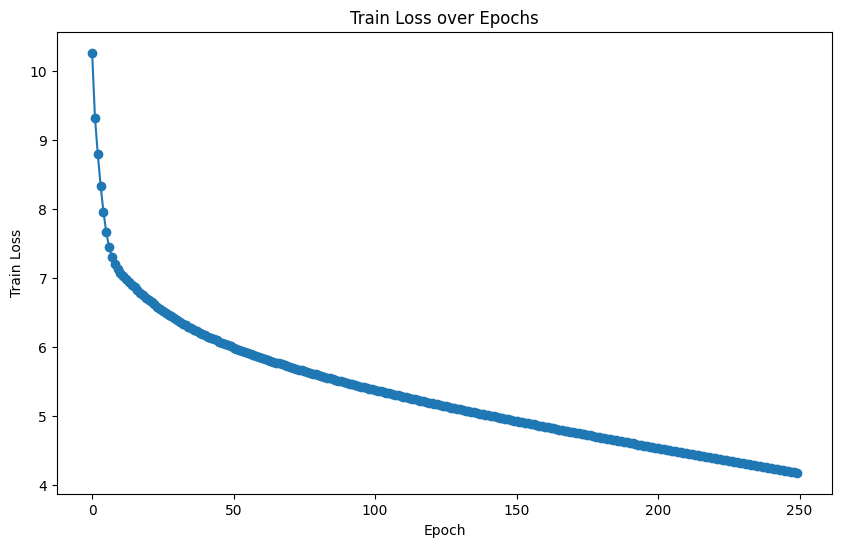

In [51]:
"""Train Loss"""

x = range(len(train_loss))
plt.figure(figsize=(10, 6))
plt.plot(x, train_loss ,'-')
plt.scatter(x, train_loss)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss over Epochs')
plt.show()

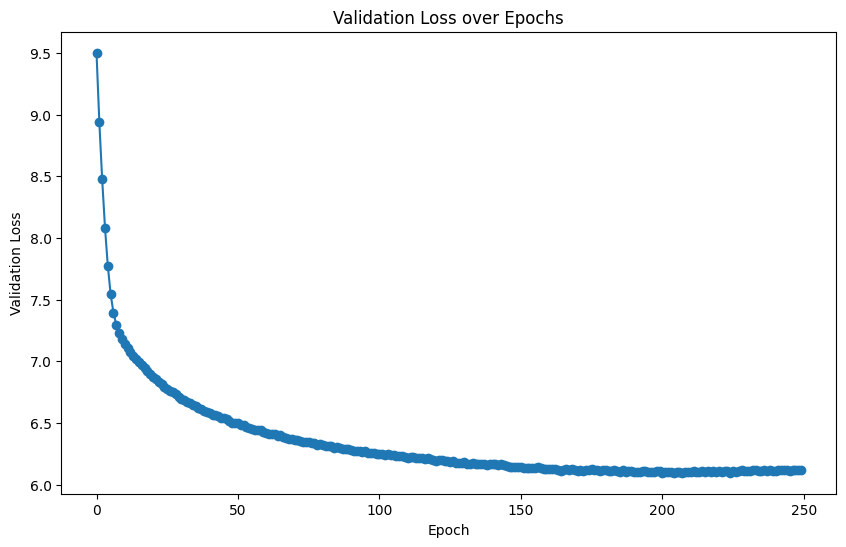

In [52]:
"""Val Loss"""

x = range(len(val_loss))
plt.figure(figsize=(10, 6))
plt.plot(x, val_loss ,'-')
plt.scatter(x, val_loss)
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss over Epochs')
plt.show()

Text(0.5, 1.0, 'Losses')

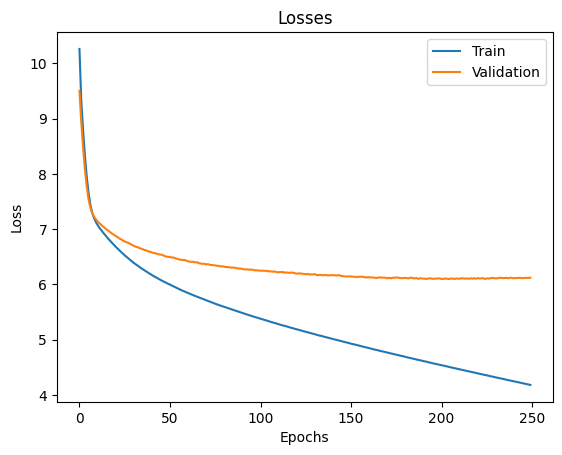

In [53]:
"""Combined Losses"""

plt.plot(train_loss, '-')
plt.plot(val_loss, '-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.title('Losses')

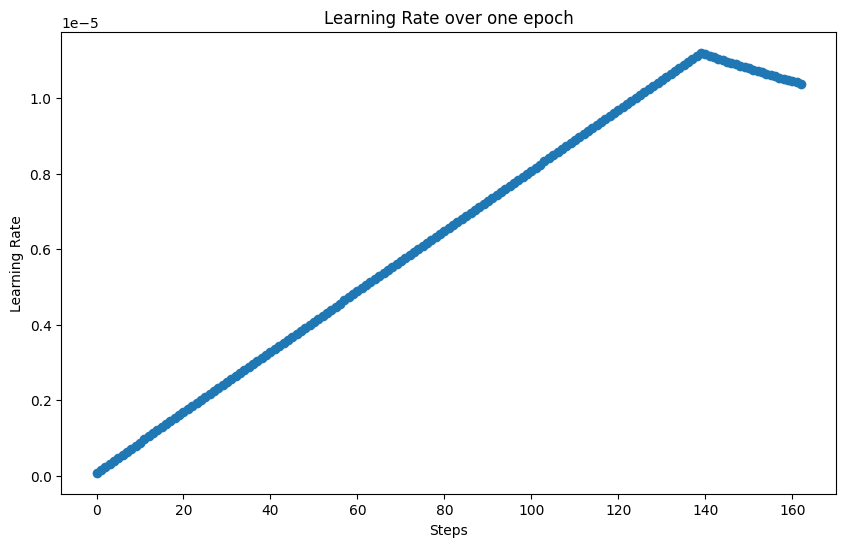

In [54]:
"""Learning rate over one epoch"""

x = range(len(LR))
plt.figure(figsize=(10, 6))
plt.plot(x, LR ,'-')
plt.scatter(x, LR)
plt.xlabel('Steps')
plt.ylabel('Learning Rate')
plt.title('Learning Rate over one epoch')
plt.show()

In [46]:
decoder.load_state_dict(torch.load('Decoder_250.pth'))

<All keys matched successfully>


(process:16416): Pango-WARNING **: 21:10:01.472: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


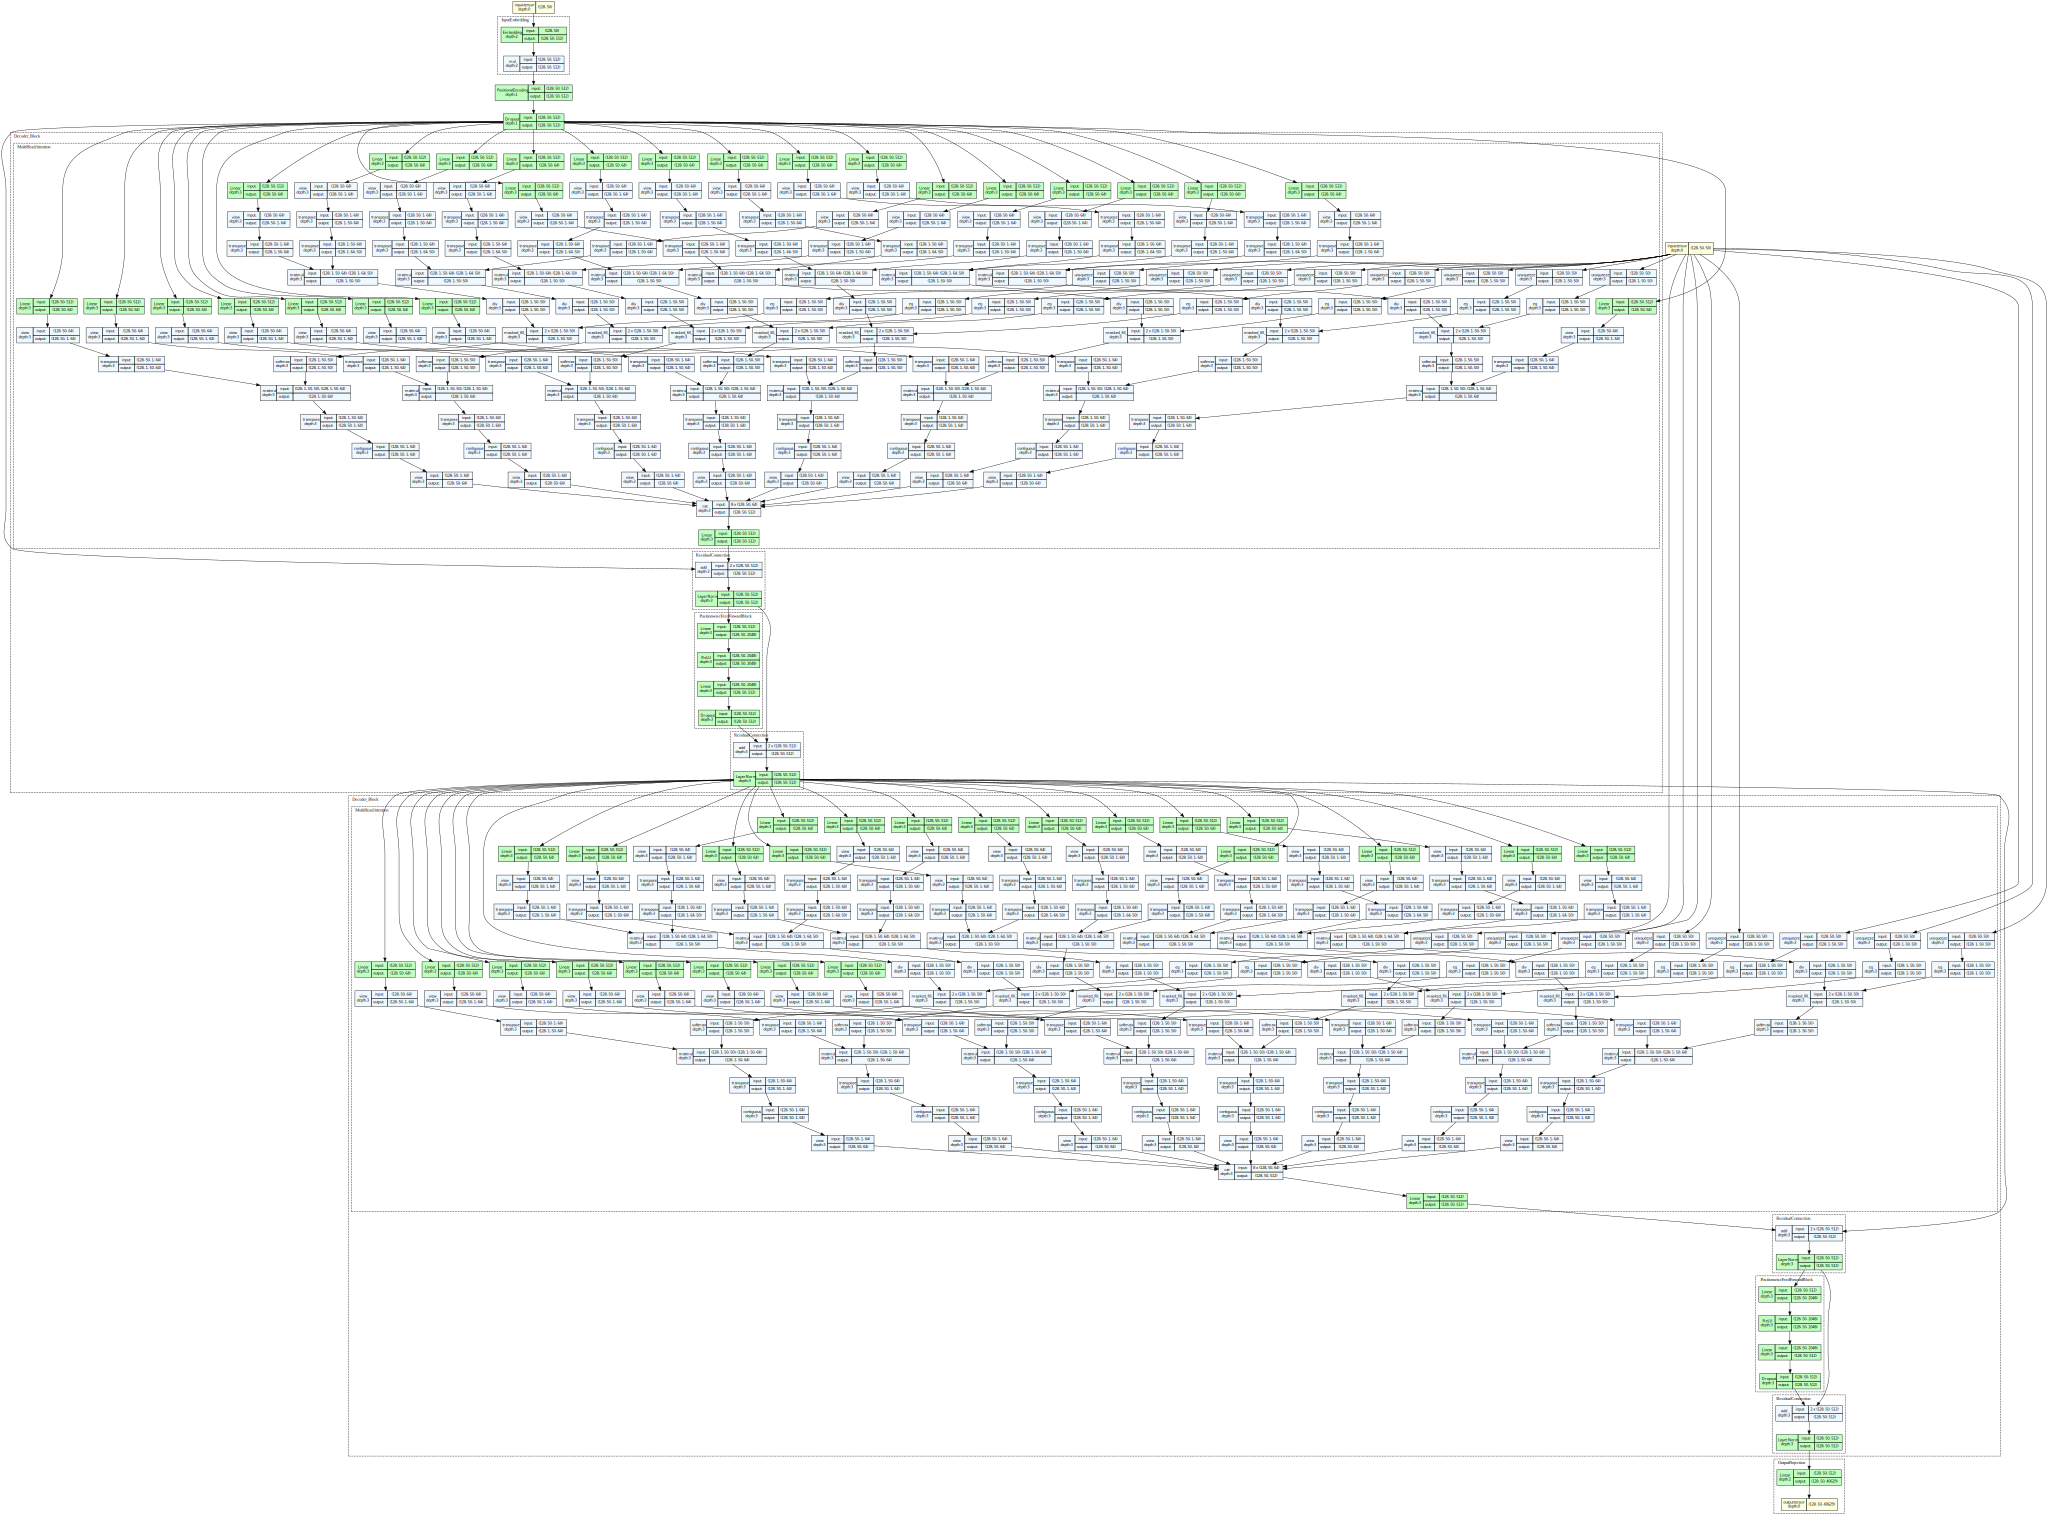

In [47]:
"""Visualization of Decoder graph using Torchview"""

model_graph = draw_graph(decoder, input_data = (x, x_mask), device = 'cuda', expand_nested = True)
model_graph.visual_graph

### 7. Inference

In [97]:
"""Beam Search"""

@torch.no_grad()
def Beam_Search_Decode(prompt_vector, model, max_length, beam_size, temperature):
    model.eval()
    candidates = [(prompt_vector, -torch.log(torch.tensor(1/len(prompt_vector))))]
    
    while True:
        new_candidates = []
        for candidate, score in candidates:
            if candidate.size(0) >= max_length:
                break
            candidate = candidate.unsqueeze(0).to(device)
            #print("Candidate size", candidate.size())
            mask_object = torch.tril(torch.ones([candidate.size(1), candidate.size(1)], dtype = torch.bool).to(device))
            mask = ((candidate != 0 ) & mask_object).unsqueeze(0).to(device)
            logits = model(candidate, mask)
            logits = logits[:, -1, :] / temperature
            
            """
                Temperature parameter is used in NLP Generative models to increase or decrease the "Confidencce" a model has in it's
                most likely response.
                Higher Temperature makes the model more creative. useful for generating purpose.
                Lower Temperature makes the model more confident useful for Question Answering.

            """
            probs = logits.softmax(dim = -1) # Calculation of Probabilites using Softmax.
            best_prob, best_prob_idx = torch.topk(probs, beam_size, dim = 1) # Obtaining top probability values based on beam size.
            for i in range(beam_size):
                token = best_prob_idx[0][i].to(device)
                token_prob = best_prob[0][i]
                # Create a new candidate by appending the token to the current candidate.
                #print(token.reshape(1))
                new_candidate = torch.cat([candidate.squeeze(), token.reshape(1)])
                #print("New candidate size", new_candidate.size())
                # We sum the log probabilities because the probabilities are in log space (Negative is because log of softmax values are negative)
                new_candidates.append((new_candidate, score - torch.log(token_prob)))
            
        candidates = sorted(new_candidates, key = lambda x: x[1], reverse = True)
            # Keep only the top k candidates
        candidates = candidates[:beam_size]
        if any([(len(cand) >= max_length) for cand, _ in candidates]):
            break
    
    return candidates[0][0].squeeze()

In [98]:
"""Greedy Search"""

@torch.no_grad()
def Greedy_Search_Decode(prompt_vector, model, max_length, temperature):
        model.eval()
        for _ in range(max_length):
                # Get the predictions
                prompt_vector = prompt_vector.unsqueeze(0).to(device)
                mask_object = torch.tril(torch.ones([prompt_vector.size(1), prompt_vector.size(1)], dtype = torch.bool).to(device))
                mask = ((prompt_vector != 0 ) & mask_object).unsqueeze(0).to(device)
                logits = model(prompt_vector, mask)

                """
                Temperature parameter is used in NLP Generative models to increase or decrease the "Confidencce" a model has in it's
                most likely response.
                Higher Temperature makes the model more creative. useful for generating purpose.
                Lower Temperature makes the model more confident useful for Question Answering.

                """
                logits = logits[:, -1, :] / temperature # Focus only on the last time step
                probs = logits.softmax(dim = -1) # Apply softmax to get probabilities
                idx_next = torch.argmax(probs, dim = 1) # Getting index of maximum probability value
                prompt_vector = torch.cat([prompt_vector.squeeze(), idx_next.reshape(1)]) # Append sampled index to the running sequence
                if prompt_vector.size(0) >= max_length:
                        break
                if prompt_vector[-1] == Vocab_dict.get('<eos>'):
                       break

        return prompt_vector[:-1].squeeze()

In [99]:
"""Function to create text from the given prompt using both beam and greedy search"""

def Inference(prompt, model, max_length, temperature, beam_size):
    tokens2int = lambda x: Vocab_dict.get(x) if x in Vocab_dict.keys() else Vocab_dict.get('<unk>')
    int2tokens = lambda x: list(Vocab_dict.keys())[list(Vocab_dict.values()).index(x)]

    prompt = preprocess_Eng(prompt)
    prompt_vector = [torch.tensor(tokens2int('<sos>'))] + [torch.tensor(tokens2int(word)) for word in prompt.split()]
    prompt_vector = torch.stack(prompt_vector)

    beam_out = Beam_Search_Decode(prompt_vector, model, max_length, beam_size, temperature)
    greedy_out = Greedy_Search_Decode(prompt_vector, model, max_length, temperature)

    beam_response = ' '.join([int2tokens(int(tensor)) for tensor in beam_out[1:] if tensor != Vocab_dict.get('<eos>')])
    greedy_response = ' '.join([int2tokens(int(tensor)) for tensor in greedy_out[1:]])

    print("Response using Beam Search: ")
    for char in beam_response:
        sys.stdout.write(char)
        time.sleep(0.01)
    print('\n') 
    print('*'*200)
    print()
    print("Response using Greedy Search: ")
    for char in greedy_response:
        sys.stdout.write(char)
        time.sleep(0.01)

In [146]:
prompt = "Today's innovation"

In [147]:
Inference(prompt, decoder, max_length, 1.2, 3)

Response using Beam Search: 
todays innovation has a big business for its a major test the new version for its own net service for its latest phoneshaped has said that is likely than a lot more important game more important game more likely that the problem are not enough people are still in

********************************************************************************************************************************************************************************************************

Response using Greedy Search: 
todays innovation is the way to be the most important game that the government has been launched in the past decade the past decade is expected to be used by the same time to be used by the uks biggest economy while exports are expected to be able

In [148]:
Inference(prompt, decoder, max_length, 0.2, 5)

Response using Beam Search: 
todays innovation it was one in new zealand in 2003 as well below analyst 1 as well below as well said he would also have done enough time for him for them under plans in an independent view from mr howard told mps it could make sure it

********************************************************************************************************************************************************************************************************

Response using Greedy Search: 
todays innovation is the way to be the most important game that the government has been launched in the past decade the past decade is expected to be used by the same time to be used by the uks biggest economy while exports are expected to be able

### 8. References:
1. [Attention Is All You Need](https://arxiv.org/abs/1706.03762).
2. [Let's build GPT: from scratch, in code, spelled out, by Andrej Karpathy](https://youtu.be/kCc8FmEb1nY?si=qEwYni3ubX3u2Cmp).
3. [Github](https://github.com/jadore801120/attention-is-all-you-need-pytorch), [Github](https://github.com/hkproj/pytorch-transformer),
[Github](https://github.com/devjwsong/transformer-translator-pytorch).